In [1]:
import numpy as np
import nibabel as nb

import ndmg as nd
import os
import re
import sys
import numpy as np
import nibabel as nb
import ndmg.utils as mgu
from argparse import ArgumentParser
from scipy import ndimage
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
from nilearn.plotting.edge_detect import _edge_map as edge_map
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
import pandas as pd
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
import math
import matplotlib.image as mpimg

init_notebook_mode(connected=True)


def plot_mtx(A, title=""):
    """
    A basic function to plot an adjacency matrix.
    """
    Adf = pd.DataFrame(A).stack().rename_axis(['y', 'x']).reset_index(name="Weight")
    trace = go.Heatmap(x=Adf.x, y=Adf.y, z=Adf.Weight)
    data = [trace]
    layout=go.Layout(width=550, height=550,
                     title=title,
                     xaxis=dict(title="Node Out"),
                     yaxis=dict(title="Node In", autorange="reversed"))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

def opaque_colorscale(basemap, reference, vmin=None, vmax=None, alpha=1):
    """
    A function to return a colorscale, with opacities
    dependent on reference intensities.
    **Positional Arguments:**
        - basemap:
            - the colormap to use for this colorscale.
        - reference:
            - the reference matrix.
    """
    reference = reference
    if vmin is not None:
        reference[reference > vmax] = vmax
    if vmax is not None:
        reference[reference < vmin] = vmin
    cmap = basemap(reference)
    maxval = np.nanmax(reference)
    # all values beteween 0 opacity and 1
    opaque_scale = alpha*reference/float(maxval)
    # remaps intensities
    cmap[:, :, 3] = opaque_scale
    return cmap


def plot_brain(brain, minthr=2, maxthr=95, edge=False):
    brain = mgu.get_braindata(brain)
    cmap = LinearSegmentedColormap.from_list('mycmap2', ['black', 'green'])
    plt.rcParams.update({'axes.labelsize': 'x-large',
                         'axes.titlesize': 'x-large'})
    fbr = plt.figure()
    if brain.shape == (182, 218, 182):
        x = [78, 90, 100]
        y = [82, 107, 142]
        z = [88, 103, 107]
    else:
        shap = brain.shape
        x = [int(shap[0]*0.35), int(shap[0]*0.51), int(shap[0]*0.65)]
        y = [int(shap[1]*0.35), int(shap[1]*0.51), int(shap[1]*0.65)]
        z = [int(shap[2]*0.35), int(shap[2]*0.51), int(shap[2]*0.65)]
    coords = (x, y, z)

    labs = ['Sagittal Slice (YZ fixed)',
            'Coronal Slice (XZ fixed)',
            'Axial Slice (XY fixed)']
    var = ['X', 'Y', 'Z']
    # create subplot for first slice
    # and customize all labels
    idx = 0
    min_val, max_val = get_min_max(brain, minthr, maxthr)
    for i, coord in enumerate(coords):
        for pos in coord:
            idx += 1
            ax = fbr.add_subplot(3, 3, idx)
            ax.set_axis_bgcolor('black')
            ax.set_title(var[i] + " = " + str(pos))
            if i == 0:
                image = ndimage.rotate(brain[pos, :, :], 90)
            elif i == 1:
                image = ndimage.rotate(brain[:, pos, :], 90)
            else:
                image = brain[:, :, pos]

            if idx % 3 == 1:
                ax.set_ylabel(labs[i])
                ax.yaxis.set_ticks([0, image.shape[0]/2, image.shape[0] - 1])
                ax.xaxis.set_ticks([0, image.shape[1]/2, image.shape[1] - 1])

            if edge:
                image = edge_map(image).data
            ax.imshow(image, interpolation='none', cmap=cmap, alpha=1,
                      vmin=min_val, vmax=max_val)

    fbr.set_size_inches(12.5, 10.5, forward=True)
    fbr.tight_layout()
    return fbr


def plot_overlays(atlas, b0, cmaps=None, minthr=2, maxthr=95, edge=False):
    plt.rcParams.update({'axes.labelsize': 'x-large',
                         'axes.titlesize': 'x-large'})
    foverlay = plt.figure()

    atlas = mgu.get_braindata(atlas)
    b0 = mgu.get_braindata(b0)
    if atlas.shape != b0.shape:
        raise ValueError('Brains are not the same shape.')
    if cmaps is None:
        cmap1 = LinearSegmentedColormap.from_list('mycmap1',
                                                  ['black', 'magenta'])
        cmap2 = LinearSegmentedColormap.from_list('mycmap2',
                                                  ['black', 'green'])
        cmaps = [cmap1, cmap2]

    if b0.shape == (182, 218, 182):
        x = [78, 90, 100]
        y = [82, 107, 142]
        z = [88, 103, 107]
    else:
        shap = b0.shape
        x = [int(shap[0]*0.35), int(shap[0]*0.51), int(shap[0]*0.65)]
        y = [int(shap[1]*0.35), int(shap[1]*0.51), int(shap[1]*0.65)]
        z = [int(shap[2]*0.35), int(shap[2]*0.51), int(shap[2]*0.65)]
    coords = (x, y, z)

    labs = ['Sagittal Slice (YZ fixed)',
            'Coronal Slice (XZ fixed)',
            'Axial Slice (XY fixed)']
    var = ['X', 'Y', 'Z']
    # create subplot for first slice
    # and customize all labels
    idx = 0
    if edge:
        min_val = 0
        max_val = 1
    else:
        min_val, max_val = get_min_max(b0, minthr, maxthr)

    for i, coord in enumerate(coords):
        for pos in coord:
            idx += 1
            ax = foverlay.add_subplot(3, 3, idx)
            ax.set_title(var[i] + " = " + str(pos))
            if i == 0:
                image = ndimage.rotate(b0[pos, :, :], 90)
                atl = ndimage.rotate(atlas[pos, :, :], 90)
            elif i == 1:
                image = ndimage.rotate(b0[:, pos, :], 90)
                atl = ndimage.rotate(atlas[:, pos, :], 90)
            else:
                image = b0[:, :, pos]
                atl = atlas[:, :, pos]

            if idx % 3 == 1:
                ax.set_ylabel(labs[i])
                ax.yaxis.set_ticks([0, image.shape[0]/2, image.shape[0] - 1])
                ax.xaxis.set_ticks([0, image.shape[1]/2, image.shape[1] - 1])
            if edge: 
                image = edge_map(image).data
                image[image > 0] = max_val
                image[image == 0] = min_val

            ax.imshow(atl, interpolation='none', cmap=cmaps[0], alpha=.9)
            ax.imshow(opaque_colorscale(cmaps[1], image, alpha=.9,
                      vmin=min_val, vmax=max_val))

    foverlay.set_size_inches(12.5, 10.5, forward=True)
    foverlay.tight_layout()
    return foverlay


def get_min_max(data, minthr=2, maxthr=95):
    '''
    data: regmri data to threshold.
    '''
    min_val = np.percentile(data, minthr)
    max_val = np.percentile(data, maxthr)
    return (min_val.astype(float), max_val.astype(float))

def side_by_side(f1, f2, t1="", t2=""):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    axes[0].imshow(f1)
    axes[1].imshow(f2)
    axes[0].set_title(t1)
    axes[1].set_title(t2)
    return fig

/usr/local/lib/python2.7/dist-packages/ndmg-0.1.1-py2.7-linux-x86_64.egg/ndmg/register/register.py:29: DeprecationWarning: Python2 support is deprecated and will be removed in a future release. Consider switching to Python3.
/usr/local/lib/python2.7/dist-packages/sklearn/utils/graph.py:16: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .graph_shortest_path import graph_shortest_path  # noqa
/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/base.py:35: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ..utils.seq_dataset import ArrayDataset, CSRDataset
/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/least_angle.py:23: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ..utils import arrayfuncs, as_float_array, check_X_y, deprecated
/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/coordin

# Master-M3R Comparison

In this notebook, we will compare the individual step-by-step outputs of `master` and `m3r-release` to figure out where they diverge. For steps with a difference, we will additionally rerun each step with the previous matching inputs to figure out exactly where the two branches diverge.

# Preprocessing

In this step, we will validate that the gradient tables are the same.

In [2]:
m3r_grad_f = '/inputs/m3r-out/tmp/sub-0025427/ses-1/dwi/preproc/sub-0025427_ses-1_dwi_1.bvec'
m3r_t1_f = '/inputs/m3r-out/tmp/sub-0025427/ses-1/dwi/preproc/sub-0025427_ses-1_dwi_t1.nii.gz'

master_grad_f = '/inputs/ndmg-out/tmp/sub-0025427/ses-1/dwi/preproc/sub-0025427_ses-1_dwi_1.bvec'
master_t1_f = '/inputs/ndmg-out/tmp/sub-0025427/ses-1/dwi/preproc/sub-0025427_ses-1_dwi_t1.nii.gz'

# load the gradient tables
m3r_grad = np.loadtxt(m3r_grad_f, delimiter=' ')
master_grad = np.loadtxt(master_grad_f, delimiter=' ')
np.testing.assert_array_equal(m3r_grad, master_grad)

# load the t1ws
m3r_t1dat = nb.load(m3r_t1_f).get_data()
master_t1dat = nb.load(master_t1_f).get_data()
np.testing.assert_array_equal(m3r_t1dat, master_t1dat)

# Registration

In this step, we will validate that the registrations produce identical outputs, up to a rotation. Recall that the master branch uses the MNI brain not in MNI space; rather, the affine is flipped. To account for this, we will compare the outputs with and without an appropriate affine flip, to see whether FLIRT is robust to arbitrary rotations. If it is non-robust to rotations, we will use the master branch code coupled with the properly-oriented brains to compute the tractography and graphs to then further check these steps for equality between the two branches.

## Unrotated

In [3]:
m3r_dwi_reg = '/inputs/m3r-out/dwi/registered/sub-0025427_ses-1_dwi_space-MNI152NLin6_res-1x1x1_registered.nii.gz'
master_dwi_reg = '/inputs/ndmg-out/reg/dwi/sub-0025427_ses-1_dwi_aligned.nii.gz'

m3r_dwidat = nb.load(m3r_dwi_reg).get_data()
master_dwidat = nb.load(master_dwi_reg).get_data()
np.testing.assert_array_equal(m3r_dwidat, master_dwidat)

AssertionError: 
Arrays are not equal

(mismatch 53.8252733421%)
 x: array([0, 0, 0, ..., 0, 0, 0], dtype=int16)
 y: array([0, 0, 0, ..., 0, 0, 0], dtype=int16)

As we can see, this is because the affines are different:

In [4]:
template = '/ndmg_atlases/atlas/MNI152NLin6_res-1x1x1_T1w.nii.gz'

print("MNI152 Affine")
print(nb.load(template).affine)
print("M3r Affine")
print(nb.load(m3r_dwi_reg).affine)
print("Master Affine")
print(nb.load(master_dwi_reg).affine)

MNI152 Affine
[[  -1.    0.    0.   90.]
 [   0.    1.    0. -126.]
 [   0.    0.    1.  -72.]
 [   0.    0.    0.    1.]]
M3r Affine
[[  -1.    0.    0.   90.]
 [   0.    1.    0. -126.]
 [   0.    0.    1.  -72.]
 [   0.    0.    0.    1.]]
Master Affine
[[ -1.   0.   0.  90.]
 [  0.  -1.   0.  91.]
 [  0.   0.   1. -72.]
 [  0.   0.   0.   1.]]


In [5]:
ref = nb.load(template).get_data()

m3r2tempim = 'm3r2temp.png'
master2tempim = 'master2temp.png'

m3r2temp = plot_overlays(b0=ref, atlas=m3r_dwidat[:,:,:,0], edge=True)
plt.savefig(m3r2tempim)
plt.close()
master2temp = plot_overlays(b0=ref, atlas=master_dwidat[:,:,:,0], edge=True)
plt.savefig(master2tempim)
plt.close()

masterim = mpimg.imread(master2tempim)
m3rim = mpimg.imread(m3r2tempim)

Below, we look at the diffusion brain's alignment with the MNI152 template at 1mm resolution and standard orientation:

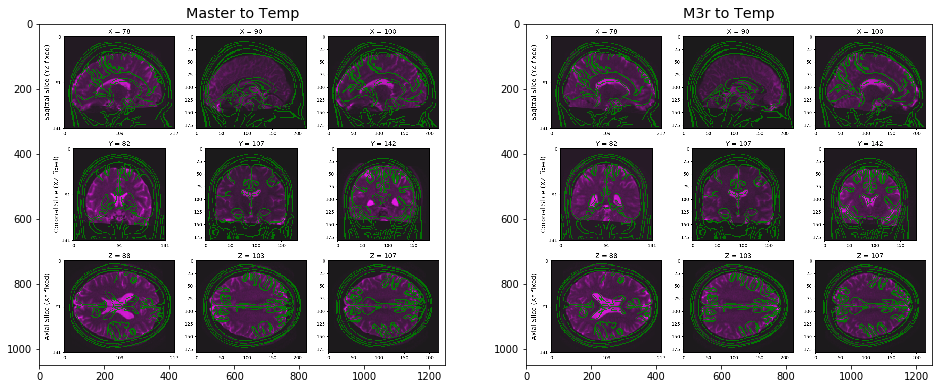

In [6]:
%matplotlib inline

dwi_cmp = side_by_side(masterim, m3rim, t1="Master to Temp", t2="M3r to Temp")
plt.close()
dwi_cmp

As we can see, the master branch is backwards wrt the MNI152 template. Since the only difference between `master` and `m3r` through tractography steps is the registration being backwards on `master`, we continue using the tractography from `m3r`, noting that I did not touch anything for preprocessing, registration, and tractography on master with the exception of reorienting everything to standard space.

In [7]:
tracks = np.load('/inputs/m3r-out/dwi/fiber/sub-0025427_ses-1_dwi_space-MNI152NLin6_res-1x1x1_fibers.npz')['arr_0']

## Graph

Finally, we compare the graph generation code, using the graphs produced by `m3r` and comparing with the graphs produced from master's copy of the graph generation code. Here, I changed the following lines:

```
def make_graph(self, streamlines, attr=None):
    """
    Takes streamlines and produces a graph
    **Positional Arguments:**
            streamlines:
                - Fiber streamlines either file or array in a dipy EuDX
                  or compatible format.
    """
    nlines = np.shape(streamlines)[0]
    print("# of Streamlines: " + str(nlines))

    print_id = np.max((int(nlines*0.05), 1))  # in case nlines*.05=0
    for idx, streamline in enumerate(streamlines):
        if (idx % print_id) == 0:
            print(idx)

        points = np.round(streamline).astype(int)
        p = set()
        for point in points:
            try:
                loc = self.rois[point[0], point[1], point[2]]
            except IndexError:
                pass
            else:
                pass

            if loc:
                p.add(loc)

**      edges = set([tuple(sorted(x)) for x in product(p, p)])
        for edge in edges:
**          lst = tuple(sorted([str(node) for node in edge]))
            self.edge_dict[lst] += 1

**  edge_list = [(str(k[0]), str(k[1]), v) for k, v in self.edge_dict.items()]
    self.g.add_weighted_edges_from(edge_list)
```

To:

```
def make_graph(self, streamlines, attr=None):
    """
    Takes streamlines and produces a graph
    **Positional Arguments:**
            streamlines:
                - Fiber streamlines either file or array in a dipy EuDX
                  or compatible format.
    """
    nlines = np.shape(streamlines)[0]
    print("# of Streamlines: " + str(nlines))

    for idx, streamline in enumerate(streamlines):
        if (idx % int(nlines*0.05)) == 0:
            print(idx)

        points = np.round(streamline).astype(int)
        p = set()
        for point in points:
            try:
                loc = self.rois[point[0], point[1], point[2]]
            except IndexError:
                pass
            else:
                pass

            if loc:
                p.add(loc)

**      edges = combinations(p, 2)
        for edge in edges:
**          lst = tuple([int(node) for node in edge])
            self.edge_dict[tuple(sorted(lst))] += 1

**  edge_list = [(k[0], k[1], v) for k, v in self.edge_dict.items()]
    self.g.add_weighted_edges_from(edge_list)
```

Note the changed lines of interest are `**`'d.

The below function is the original graphgen code from master:

In [8]:
from __future__ import print_function

from itertools import combinations
from collections import defaultdict
import numpy as np
import networkx as nx
import nibabel as nb
import ndmg
import time


class graph_master(object):
    def __init__(self, N, rois, attr=None, sens="dwi"):
        """
        Initializes the graph with nodes corresponding to the number of ROIs
        **Positional Arguments:**
                N:
                    - Number of rois
                rois:
                    - Set of ROIs as either an array or niftii file)
                attr:
                    - Node or graph attributes. Can be a list. If 1 dimensional
                      will be interpretted as a graph attribute. If N
                      dimensional will be interpretted as node attributes. If
                      it is any other dimensional, it will be ignored.
        """
        self.N = N
        self.edge_dict = defaultdict(int)

        self.rois = nb.load(rois).get_data()
        n_ids = np.unique(self.rois)
        n_ids = n_ids[n_ids != 0]

        self.g = nx.Graph(name="Generated by NeuroData's MRI Graphs (ndmg)",
                          date=time.asctime(time.localtime()),
                          source="http://m2g.io",
                          region="brain",
                          sensor=sens,
                          ecount=0,
                          vcount=len(n_ids)
                          )
        print(self.g.graph)

        [self.g.add_node(ids) for ids in n_ids]
        pass

    def make_graph(self, streamlines, attr=None):
        """
        Takes streamlines and produces a graph
        **Positional Arguments:**
                streamlines:
                    - Fiber streamlines either file or array in a dipy EuDX
                      or compatible format.
        """
        nlines = np.shape(streamlines)[0]
        print("# of Streamlines: " + str(nlines))

        for idx, streamline in enumerate(streamlines):
            if (idx % int(nlines*0.05)) == 0:
                print(idx)

            points = np.round(streamline).astype(int)
            p = set()
            for point in points:
                try:
                    loc = self.rois[point[0], point[1], point[2]]
                except IndexError:
                    pass
                else:
                    pass

                if loc:
                    p.add(loc)

            edges = combinations(p, 2)
            for edge in edges:
                lst = tuple([int(node) for node in edge])
                self.edge_dict[tuple(sorted(lst))] += 1

        edge_list = [(k[0], k[1], v) for k, v in self.edge_dict.items()]
        self.g.add_weighted_edges_from(edge_list)

    def cor_graph(self, timeseries, attr=None):
        """
        Takes timeseries and produces a correlation matrix
        **Positional Arguments:**
            timeseries:
                -the timeseries file to extract correlation for.
                          dimensions are [numrois]x[numtimesteps]
        """
        print("Estimating correlation matrix for {} ROIs...".format(self.N))
        cor = np.corrcoef(timeseries)  # calculate pearson correlation

        roilist = np.unique(self.rois)
        roilist = roilist[roilist != 0]
        roilist = np.sort(roilist)

        for (idx_out, roi_out) in enumerate(roilist):
            for (idx_in, roi_in) in enumerate(roilist):
                self.edge_dict[tuple((roi_out, roi_in))] = float(np.absolute(
                    cor[idx_out, idx_in]))

        edge_list = [(k[0], k[1], v) for k, v in self.edge_dict.items()]

        self.g.add_weighted_edges_from(edge_list)
        pass

    def get_graph(self):
        """
        Returns the graph object created
        """
        try:
            return self.g
        except AttributeError:
            print("Error: the graph has not yet been defined.")
            pass

    def save_graph(self, graphname, fmt='edgelist'):
        """
        Saves the graph to disk
        **Positional Arguments:**
                graphname:
                    - Filename for the graph
        **Optional Arguments:**
                fmt:
                    - Output graph format
        """
        self.g.graph['ecount'] = nx.number_of_edges(self.g)
        g = nx.convert_node_labels_to_integers(self.g, first_label=1)
        if fmt == 'edgelist':
            nx.write_weighted_edgelist(g, graphname, encoding='utf-8')
        elif fmt == 'gpickle':
            nx.write_gpickle(g, graphname)
        elif fmt == 'graphml':
            nx.write_graphml(g, graphname)
        else:
            raise ValueError('edgelist, gpickle, and graphml currently supported')
        pass

    def summary(self):
        """
        User friendly wrapping and display of graph properties
        """
        print("\n Graph Summary:")
        print(nx.info(self.g))
        pass


In [9]:
parc = '/ndmg_atlases/label/desikan_res-1x1x1.nii.gz'
# make the graph with m3r's graphgen code, which is on branch m3r
m3r_graph = nd.graph(np.unique(nb.load(parc).get_data()) - 1, parc)
m3r_graph.make_graph(tracks)

{'ecount': 0, 'vcount': 70, 'region': 'brain', 'source': 'http://m2g.io', 'version': '0.1.1', 'date': 'Sun Jan  6 00:14:33 2019', 'sensor': 'dwi', 'name': "Generated by NeuroData's MRI Graphs (ndmg)"}
# of Streamlines: 839689
0
41984
83968
125952
167936
209920
251904
293888
335872
377856
419840
461824
503808
545792
587776
629760
671744
713728
755712
797696
839680


In [10]:
# make the graph using master's original graphgen code above
master_graph = graph_master(np.unique(nb.load(parc).get_data()) - 1, parc)
master_graph.make_graph(tracks)

{'source': 'http://m2g.io', 'ecount': 0, 'vcount': 70, 'date': 'Sun Jan  6 00:17:30 2019', 'region': 'brain', 'sensor': 'dwi', 'name': "Generated by NeuroData's MRI Graphs (ndmg)"}
# of Streamlines: 839689
0
41984
83968
125952
167936
209920
251904
293888
335872
377856
419840
461824
503808
545792
587776
629760
671744
713728
755712
797696
839680


In [11]:
master_graph.g.nodes() == m3r_graph.g.nodes()

True

In [12]:
master_adj = nx.to_numpy_matrix(master_graph.g)
m3r_adj = nx.to_numpy_matrix(m3r_graph.g)
np.fill_diagonal(m3r_adj, 0)
np.testing.assert_equal(master_adj, m3r_adj)

Showing that if the brains are registered properly on master (and hence, the tracts are properly registered) the resulting graphs are the same. Finally, just to be doubly sure, we will visualize the parcellation with MNI152:

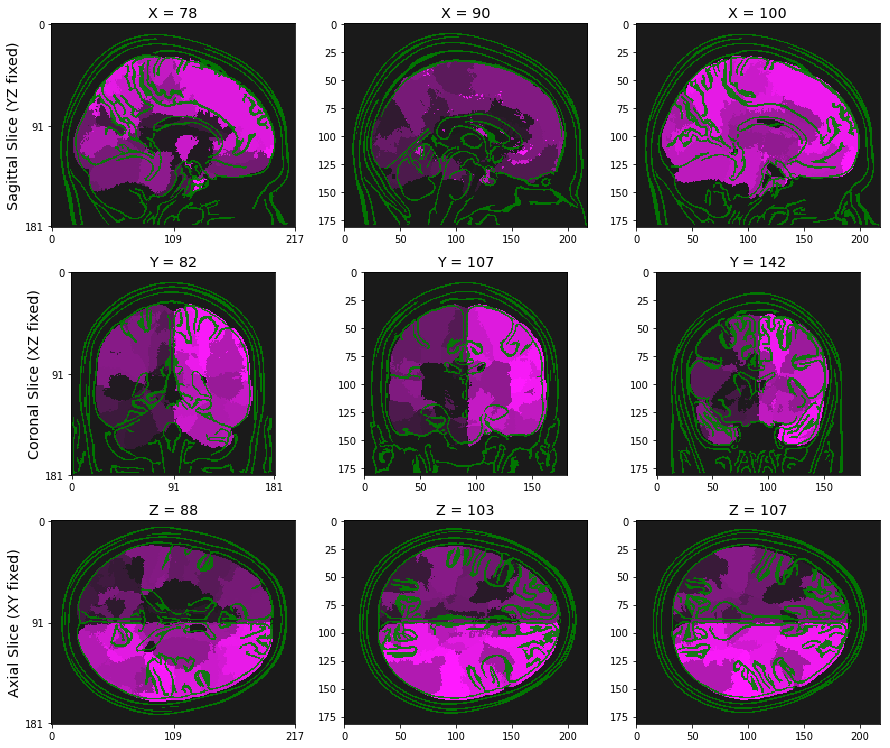

In [13]:
parc_dat = nb.load(parc).get_data()
f = plot_overlays(b0=ref, atlas=parc_dat, edge=True)
plt.close()
f

Recall that the dwi image for M3r is shown above to be properly aligned with the properly oriented MNI152. Then by transitivity we can conclude that the `dwi` brain aligns properly with the parcellation as well.